In [1]:
# 01-Ratios.ipynb

In [2]:
import pickle 

with open("/Users/devaldeliwala/mulab/outputs/MCMC/slopes.pkl", "rb") as f: 
    slopes = pickle.load(f) 

In [3]:
with open("/Users/devaldeliwala/mulab/outputs/MCMC/slopes_back.pkl", "wb") as f: 
    pickle.dump(slopes, f)

In [4]:
NRCB1 = slopes["NRCB1"] 
NRCB2 = slopes["NRCB2"] 
NRCB3 = slopes["NRCB3"] 
NRCB4 = slopes["NRCB4"]

In [5]:
def extinction_ratios_from_slopes(slope_dict):
    """
    Convert CMD slopes  A_filty / E(filt1–F212N)  to A_filter / A_F212N,
    propagating 1‑sigma errors.

    Keys must be one of
        'F115W-F212N_F115W'
        'F212N-F323N_<F323N|F212N>'
        'F212N-F405N_F212N'
        
    Values are (slope, slope_err) or None.
    """
    out = {}

    for key, value in slope_dict.items():
        if value is None:
            continue                       
            
        R, sR = value                      
        color, fy = key.split('_')
        f1,  f2 = color.split('-')         

        if f1 != 'F212N':
            num = f1
            if fy == f1:                   
                r   = R / (R - 1.0)
                sr  = sR / (R - 1.0)**2
            else:                          
                r   = 1.0 - 1.0 / R
                sr  = sR / R**2
        else:                             
            num = f2
            if fy == 'F212N':              
                r  = 1.0 - 1.0 / R
                sr = sR / R**2
            else:
                r  = (R - 1.0) / R
                sr = sR / R**2
        out[f"A{num}/AF212N"] = (r, sr)
    return out


In [6]:
extinction_NRCB1 = extinction_ratios_from_slopes(NRCB1) 
extinction_NRCB2 = extinction_ratios_from_slopes(NRCB2) 
extinction_NRCB3 = extinction_ratios_from_slopes(NRCB3)  
extinction_NRCB4 = extinction_ratios_from_slopes(NRCB4) 

extinction_ratios = {
    "NRCB1": extinction_NRCB1, 
    "NRCB2": extinction_NRCB2, 
    "NRCB3": extinction_NRCB3, 
    "NRCB4": extinction_NRCB4, 
}

In [7]:
with open("/Users/devaldeliwala/mulab/outputs/FINAL/ratios.pkl", "wb") as f: 
    pickle.dump(extinction_ratios, f)

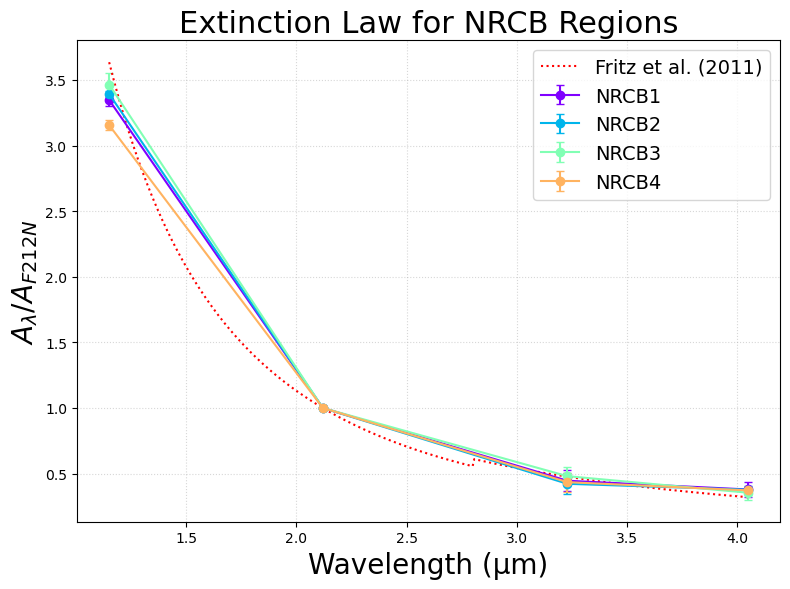

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from cycler import cycler

nice5 = plt.get_cmap("rainbow")(np.linspace(0,1,5))
plt.rcParams["axes.prop_cycle"] = cycler(color=nice5)

wavelengths = {
    'F115W': 1.15,
    'F212N': 2.12,
    'F323N': 3.23,
    'F405N': 4.05
}

fig, ax = plt.subplots(figsize=(8,6))
for region, ratios in extinction_ratios.items():
    x = np.array([
        wavelengths['F115W'],
        wavelengths['F212N'],
        wavelengths['F323N'],
        wavelengths['F405N']
    ])
    y = np.array([
        ratios['AF115W/AF212N'][0],
        1.0,
        ratios['AF323N/AF212N'][0],
        ratios['AF405N/AF212N'][0]
    ])
    yerr = np.array([
        ratios['AF115W/AF212N'][1],
        0.0,
        ratios['AF323N/AF212N'][1],
        ratios['AF405N/AF212N'][1]
    ])

    ax.errorbar(x, y, yerr=yerr, fmt='o-', capsize=3, label=region)

# new piecewise extinction law
lambda_ref = np.linspace(1.15, 4.05, 400)

# normalized A(λ) at 2.12 µm
A2p12 = 1.0  # by definition of Aλ/A2.12

# Fritz broken power law 
# \alpha = 2.11 for \lambda \in (1.15, 2.8µm) 
# \alpha = 1.76 for \lambda \in (2.8, 4.05µm) 
pw = np.where(
    lambda_ref < 2.8,
    (lambda_ref/2.12)**(-2.11),
    (lambda_ref/2.12)**(-1.76),
)

ax.plot(lambda_ref, pw, 'r:', lw=1.5, label='Fritz et al. (2011)')

ax.set_xlabel('Wavelength (µm)', fontsize=20)
ax.set_ylabel(r'$A_\lambda / A_{F212N}$', fontsize=20)
ax.set_title('Extinction Law for NRCB Regions', fontsize=22)
ax.legend(loc='upper right', fontsize=14)
ax.grid(alpha=0.5, linestyle=':')

plt.tight_layout()
plt.savefig("/Users/devaldeliwala/mulab/paper/imgs/extinction_law.png", dpi=300)
plt.show()

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import norm

def plot_pairwise_significance(data_dict, *, ratios=None, alpha=0.05):
    """
    Parameters
    ----------
    data_dict : dict
        Outer keys = regions; inner keys = ratio labels;
        values = (mean, σ) tuples.
    ratios : list[str] | None
        Which ratios (inner keys) to plot and in what order.
        Default = the order that appears in the first region.
    alpha : float
        Significance level used for asterisk annotation.
    """
    regions = list(data_dict.keys())
    if ratios is None:
        # Preserve the order that appears in the first region
        ratios = list(next(iter(data_dict.values())).keys())

    n_reg = len(regions)
    n_rat = len(ratios)

    fig, axes = plt.subplots(
        1, n_rat, figsize=(4 * n_rat + 1.5, 4), constrained_layout=True
    )

    # Convenience arrays for text colours
    txt_light = "#f2f2f2"
    txt_dark  = "#111111"

    for ax, ratio in zip(np.ravel(axes), ratios):
        # Build arrays of means and σ for this ratio
        mu   = np.array([data_dict[r][ratio][0] for r in regions])
        sigma = np.array([data_dict[r][ratio][1] for r in regions])

        # Pair‑wise Z‑tests
        Z = (mu[:, None] - mu[None, :]) / np.sqrt(sigma[:, None] ** 2 +
                                                  sigma[None, :] ** 2)
        P = 2.0 * norm.sf(np.abs(Z))        # two‑tailed

        # Diagonal cells are undefined / self‑comparison
        np.fill_diagonal(P, np.nan)
        np.fill_diagonal(Z, np.nan)

        im = ax.imshow(
            P,
            norm=LogNorm(vmin=1e-6, vmax=1),
            cmap="magma",   # any perceptually‑uniform cmap works
        )

        # Annotate each cell
        for i in range(n_reg):
            for j in range(n_reg):
                if i == j:
                    continue
                p_val = P[i, j]
                z_val = Z[i, j]
                star  = " *" if p_val < alpha else ""
                txt   = f"p={p_val:0.3f}\nz={z_val:+0.3f}\n{star}"
                # set text colour for readability on dark/light cells
                ax.text(
                    j,
                    i,
                    txt,
                    ha="center",
                    va="center",
                    fontsize=8,
                    color=txt_light if p_val < 0.01 else txt_dark,
                )

        # Beautify
        ax.set_xticks(range(n_reg), regions, rotation=45, ha="right", fontsize=12)
        ax.set_yticks(range(n_reg), regions, fontsize=12)
        ax.set_title(ratio, fontsize=18)
        ax.set_xlabel("Regions", fontsize=18)
        ax.set_ylabel("Regions", fontsize=18)

    # One shared colour‑bar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=1, pad=0.02)
    cbar.set_label("p-value (log scale)")

    fig.suptitle("Pairwise Statistical Significance of Extinction Ratios Across NRCB Regions",
                 fontsize=20, y=1.1)

    fig.savefig("/Users/devaldeliwala/mulab/paper/imgs/stat_significance.png", dpi=300)
    plt.show()

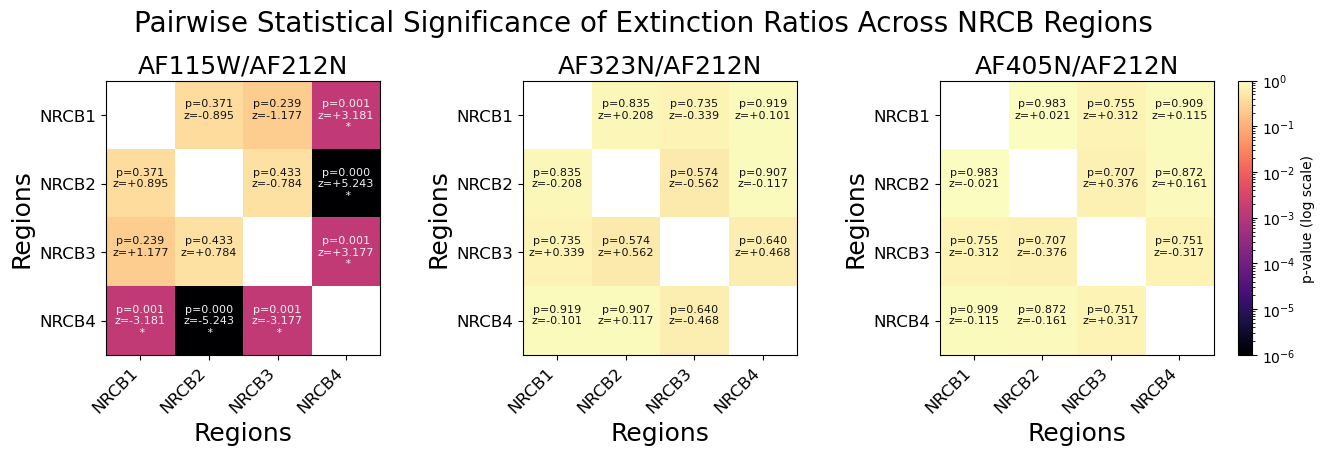

In [27]:
plot_pairwise_significance(extinction_ratios)

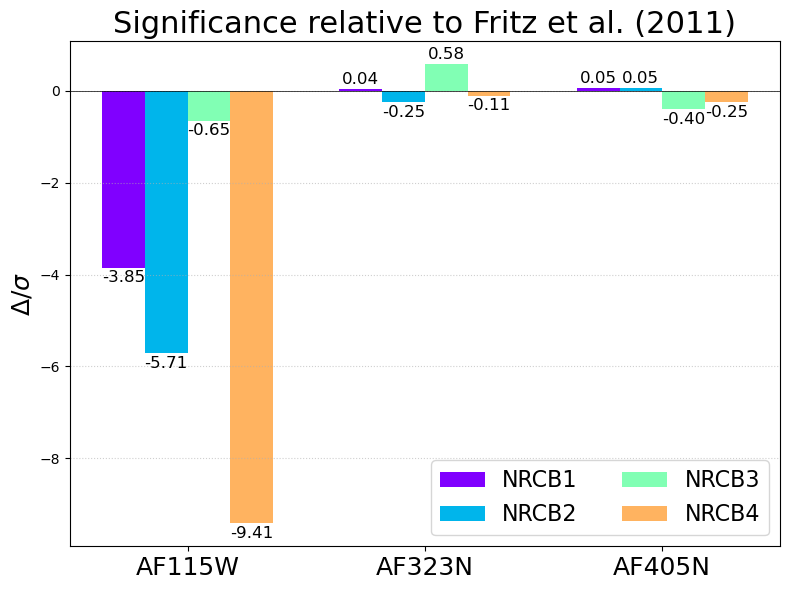

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

nice5 = plt.get_cmap("rainbow")(np.linspace(0,1,5))
plt.rcParams["axes.prop_cycle"] = cycler(color=nice5)

wavelengths = np.array([1.15, 2.12, 3.23, 4.05])
alpha = np.where(wavelengths < 2.8, 2.11, 1.76)
A = wavelengths**(-alpha)
A /= A[wavelengths == 2.12]

regions = list(extinction_ratios.keys())
bands   = ['AF115W/AF212N', 'AF323N/AF212N', 'AF405N/AF212N']
x = np.arange(len(bands))
width = 0.18

fig, ax = plt.subplots(figsize=(8,6))

for i, region in enumerate(regions):
    sigmas = []
    for band in bands:
        meas, err = extinction_ratios[region][band]
        ref       = fritz_vals[band]
        sigmas.append((meas - ref) / err)
    bars = ax.bar(x + (i - 1.5)*width, sigmas, width, label=region)
    
    # annotate each bar
    for bar, sigma in zip(bars, sigmas):
        height = bar.get_height()
        sign = np.sign(height)
        # offset a bit above or below the bar
        y = height + 0.05*sign
        va = 'bottom' if sign >= 0 else 'top'
        ax.text(
            bar.get_x() + bar.get_width()/2,  # x-position: center of bar
            y,                                # y-position: just outside bar
            f"{sigma:.2f}",                   # formatted text
            ha='center', 
            va=va,
            fontsize=12
        )

# horizontal zero line
ax.axhline(0, color='k', lw=0.5)

ax.set_xticks(x)
ax.set_xticklabels([b.split('/')[0] for b in bands], fontsize=18)
ax.set_ylabel(r'$\Delta/\sigma$', fontsize=18)
ax.set_title(r'Significance relative to Fritz et al. (2011)', fontsize=22)
ax.legend(ncol=2, fontsize=16)
ax.grid(axis='y', ls=':', alpha=0.6)
plt.tight_layout()
plt.savefig("/Users/devaldeliwala/mulab/paper/imgs/stat_significance_fritz.png", dpi=300)
plt.show()


In [68]:
extinction_ratios

{'NRCB1': {'AF115W/AF212N': (3.3468528884194937, 0.04577874512570838),
  'AF323N/AF212N': (0.4456093601883146, 0.07909094736579922),
  'AF405N/AF212N': (0.37886756740797034, 0.057421843097529804)},
 'NRCB2': {'AF115W/AF212N': (3.39265150286147, 0.022840775115475716),
  'AF323N/AF212N': (0.4221685987745841, 0.08013729060191235),
  'AF405N/AF212N': (0.37751340703599, 0.030178407211291215)},
 'NRCB3': {'AF115W/AF212N': (3.464879766814625, 0.08922704256202735),
  'AF323N/AF212N': (0.48048376570185886, 0.06597345097516374),
  'AF405N/AF212N': (0.3541997564969819, 0.054204440748731236)},
 'NRCB4': {'AF115W/AF212N': (3.155398174719087, 0.03906620138278873),
  'AF323N/AF212N': (0.4347806148203242, 0.07204005818440924),
  'AF405N/AF212N': (0.3720552724069244, 0.015467887535537081)}}

In [69]:
slopes

{'NRCB1': {'F115W-F212N_F115W': (1.426102549901821, 0.008311743836021464),
  'F212N-F323N_F323N': (1.8037822578311902, 0.25733271337688646),
  'F212N-F405N_F212N': (1.6099626223459773, 0.14883624850734387)},
 'NRCB2': {'F115W-F212N_F115W': (1.4179463656968259, 0.003989807515969149),
  'F212N-F323N_F323N': (1.7306086133070733, 0.24001167999635772),
  'F212N-F405N_F212N': (1.6064603018009362, 0.07788185915086111)},
 'NRCB3': {'F115W-F212N_F115W': (1.4056993016305637, 0.014686050549538832),
  'F212N-F323N_F212N': (0.7846759795754291, 0.09567312262429815),
  'F212N-F405N_F212N': (1.548466433793357, 0.12996860547259753),
  'F212N-F323N_F323N': (1.924867663377229, 0.24443925721600876)},
 'NRCB4': {'F115W-F212N_F115W': (1.4639513996667135, 0.008409035056164848),
  'F212N-F323N_F323N': (1.7692245280690668, 0.22549657935540068),
  'F212N-F405N_F212N': (1.5924968489392681, 0.03922727762124363)}}

In [30]:
fritz_vals

{'AF115W/AF212N': 3.634931436280668,
 'AF212N/AF212N': 1.0,
 'AF323N/AF212N': 0.6199722162731551,
 'AF405N/AF212N': 0.41633970073376225}

In [31]:
1.3963332346626527 / (1.3963332346626527 - 1)

3.5231293077179635

In [32]:
(1.793460179604495 - 1)/ (1.793460179604495)

0.44241862106995533

In [33]:
(1.6023454295943191 - 1)/ (1.6023454295943191)

0.3759148423737949

In [34]:
fritz_vals = {
    'AF115W/AF212N': 3.5231293077179635,
    'AF212N/AF212N': 1.0,
    'AF323N/AF212N': 0.44241862106995533, 
    'AF405N/AF212N': 0.3759148423737949, 
}

{'AF115W/AF212N': (3.155398174719087, 0.03906620138278873),
 'AF323N/AF212N': (0.4347806148203242, 0.07204005818440924),
 'AF405N/AF212N': (0.3720552724069244, 0.015467887535537081)}